# WDSR

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from data import Thermal
from train import WdsrTrainer
from model.wdsr_edge import wdsr_b

#from tensorflow.compat.v2.keras.utils import multi_gpu_model
import argparse

%matplotlib inline

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Number of residual blocks
depth = 32

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [3]:
# Location of model weights (needed for demo)
weights_dir = f'weights/wdsr-b-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'canweights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Preprocessing the Image to Edge Form:

## Training Part:

In [4]:
Thermal_train = Thermal(scale=scale, subset='train', downgrade=downgrade)
Thermal_valid = Thermal(scale=scale, subset='valid', downgrade=downgrade)

In [5]:
train_ds = Thermal_train.dataset(batch_size=16, random_transform=True)
valid_ds = Thermal_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

LR_Image Directory:
data/Thermal_train_LR_bicubic/X4
HR_Image Directory:
data/Thermal_train_HR
LR_Image Directory:
data/Thermal_valid_LR_bicubic/X4
HR_Image Directory:
data/Thermal_valid_HR


### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-wdsr-b-32-x4.tar.gz](https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/wdsr-b-32-x4` directory containing the weights of the pre-trained model.

In [6]:
trainer = WdsrTrainer(model=wdsr_b(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/n20ncan_edge_wdsr-b-{depth}-x{scale}')

# n3ncan_edge ======> Dense Residual Block
# n4ncan_edge ======> Dense Residual Block with BatchNormalization with edge extraction (Wrong Method for Edge Extraction)
# n7ncan_edge ======> Dense Residual Block without the 1st BatchNormalization (Better with Batch Normalization)
# n8ncan_edge ======> Dense Residual Block without the 2nd BatchNormalization (Better with Batch Normalization)
# n15ncan_edge ======> WDSR with Edge Detection
# n16ncan_edge ======> WDSR with Batch Normalization
# n17ncan_edge ======> WDSR with Edge Extraction, Batch Normalization and Optimizer
# n18ncan_edge ======> WDSR with Edge Detection and Batch Normalization
# n19ncan_edge ======> WDSR with Batch Normalization and Optimizer
# n20ncan_edge ======> Dense Residual Block with Edge Detection
# n21ncan_edge ======> Dense Residual Block with Edge Detection, Batch Normalization, and Optimizer

# Train WDSR B model for 300,000 steps and evaluate model|
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
# Train WDSR B model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
            valid_ds.take(10),
            steps=100000, 
            evaluate_every=1000, 
            save_best_only=True)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
1000/100000: loss = 15805622272.000, PSNR = 5.974515 (235.48s)
2000/100000: loss = 116566040.000, PSNR = 6.064779 (194.67s)
3000/100000: loss = 39240720.000, PSNR = 5.924691 (194.37s)
4000/100000: loss = 16261110.000, PSNR = 5.954680 (194.39s)
5000/100000: loss = 7695174.000, PSNR = 5.877305 (194.71s)
6000/100000: loss = 3709458.750, PSNR = 5.791502 (195.09s)
7000/100000: loss = 1946106.000, PSNR = 5.817211 (194.97s)
8000/100000: loss = 999888.188, PSNR = 5.677003 (194.85s)
9000/100000: loss = 579415.625, PSNR = 5.658422 (194.82s)
10000/100000: loss = 329705.062, PSNR = 5.491875 (194.92s)
11000/100000: loss = 185136.188, PSNR = 5.613771 (194.58s)
12000/100000: loss = 111769.953, PSNR = 5.943951 (194.34s)
13000/100000: loss = 69532.320, PSNR = 6.

In [7]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Restoring from .ckpt/n20ncan_edge_wdsr-b-32-x4/ckpt-50
Model restored from checkpoint at step 92000.


In [8]:
# Evaluate model on full validation set
psnr = trainer.evaluate(valid_ds)
print(f'PSNR = {psnr.numpy():3f}')

PSNR = 38.933418


In [9]:
# Save weights to separate location (needed for demo)
weights_dir = f'weights/wdsr-b-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'n20ncan_edgeweights.h5')
trainer.model.save_weights(weights_file)

## Demo

In [10]:
model = wdsr_b(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [11]:
from model import resolve_single
from utils import load_image, plot_sample
import cv2
import numpy as np
import tensorflow as tf
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
import cv2

def resolve_and_plot(lr_image_path, hr_image_path):
    lr = load_image(lr_image_path)
    lr = cv2.cvtColor(lr, cv2.COLOR_GRAY2BGR)
    hr = load_image(hr_image_path)
    sr = resolve_single(model, lr)
    #print(hr.shape)
    #print(sr.shape)    
    plot_sample(lr, sr, hr)
    mse = tf.keras.losses.MeanSquaredError()
    sr2 = cv2.cvtColor(np.float32(sr), cv2.COLOR_BGR2GRAY)
    ssim_e = ssim(sr2, hr, data_range=hr.max() - hr.min())
    print(ssim_e)
    #err = mse(hr, sr2).numpy()
    #print("The mean square error of the two images is:")
    #print(err)
    

0.9840610320050056


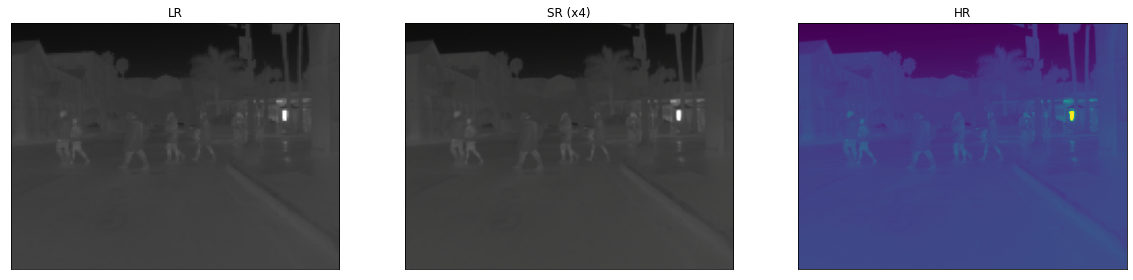

In [12]:
resolve_and_plot('demo/0004x4.png','demo/0004.png')

0.9623206751144555


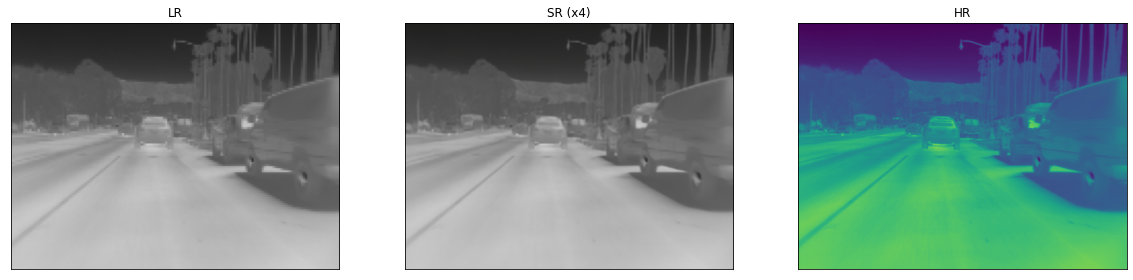

In [13]:
resolve_and_plot('demo/1064x4.png','demo/1064.png')

0.8932869549987282


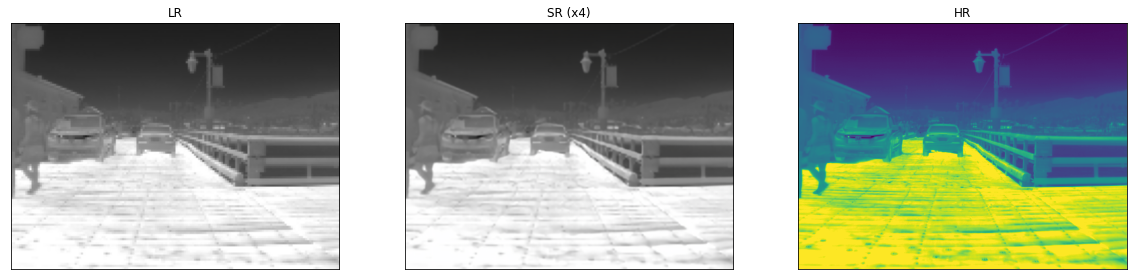

In [14]:
resolve_and_plot('demo/0303x4.png','demo/0303.png')